In [1]:
import pandas as pd
import numpy as np
import os
import glob
import random
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
def preprocess_data(data, is_train=True):
    
    temp = data.copy()
    temp = temp[['Day','Hour', 'TARGET', 'DHI', 'DNI', 'WS', 'RH', 'T']]

    if is_train==True:          
    
        temp['Target1'] = temp['TARGET'].shift(-48).fillna(method='ffill')
        temp['Target2'] = temp['TARGET'].shift(-48*2).fillna(method='ffill')
        temp = temp.dropna()
        
        return temp.iloc[:-96]

    elif is_train==False:
        
        temp = temp[['Day','Hour', 'TARGET', 'DHI', 'DNI', 'WS', 'RH', 'T']]
                              
        return temp.iloc[-48:, :]

In [3]:
train = pd.read_csv('./data/train/train.csv')

test = []

for i in range(81):
    file_path = './data/test/' + str(i) + '.csv'
    temp = pd.read_csv(file_path)
    temp['Day'] = i
    temp = preprocess_data(temp, is_train=False)
    test.append(temp)

df_test = pd.concat(test)

submission = pd.read_csv('./data/sample_submission.csv')

In [4]:
df_train = preprocess_data(train)

df_train.shape, df_test.shape

((52464, 10), (3888, 8))

In [5]:
df_train.WS = np.log1p(df_train.WS)
df_test.WS = np.log1p(df_test.WS)

In [6]:
min = df_train[['Day','Hour','DHI','DNI','WS','RH','T']].min()
max  = df_train[['Day','Hour','DHI','DNI','WS','RH','T']].max()

In [7]:
for i, col in enumerate(['Day','Hour','DHI','DNI','WS','RH','T']):
    df_train[col] = (df_train[col] - min[i]) / (max[i] - min[i])
    df_test[col] = (df_test[col] - min[i]) / (max[i] - min[i])

In [8]:
Day0 = df_train.iloc[:, :-2]
Day  = df_train.iloc[:, 1:-2]
Day7 = df_train.iloc[:, -2]
Day8 = df_train.iloc[:, -1]
Day78 = df_train.iloc[:, -2:]

df_test0 = df_test.copy()
df_test = df_test.iloc[:, 1:]

In [9]:
def quantile_loss(q, y, pred):
    err = (y-pred)
    return mean(maximum(q*err, (q-1)*err), axis=-1)

In [10]:
q_lst = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_valid, Y_train, Y_valid = train_test_split(Day, Day78, test_size=0.25, random_state=42)

X_train_1, X_valid_1, Y_train_1, Y_valid_1 = train_test_split(Day, Day7, test_size=0.25, random_state=42)
X_train_2, X_valid_2, Y_train_2, Y_valid_2 = train_test_split(Day, Day8, test_size=0.25, random_state=42)

X_train.shape, X_valid.shape, Y_train.shape, Y_valid.shape

((39348, 7), (13116, 7), (39348, 2), (13116, 2))

In [12]:
import tensorflow as tf
from tensorflow.keras import datasets
from tensorflow.keras import layers
from tensorflow.keras.backend import mean, maximum

tf.random.set_seed(42)

epoch = 100

In [13]:
model = tf.keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(Day.shape)),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(2)
])

model.compile(loss='mse', optimizer='adam')
hist = model.fit(X_train, Y_train, epochs=epoch, batch_size=48, validation_split=0.25, 
callbacks = [tf.keras.callbacks.EarlyStopping(patience=3, mode='min', monitor='val_loss', verbose=1)])
model.evaluate(X_valid, Y_valid)

Epoch 1/100
615/615 [==============================] - 2s 2ms/step - loss: 367.3883 - val_loss: 178.8931
Epoch 2/100
615/615 [==============================] - 1s 1ms/step - loss: 171.6994 - val_loss: 158.0998
Epoch 3/100
615/615 [==============================] - 1s 1ms/step - loss: 153.0226 - val_loss: 150.6760
Epoch 4/100
615/615 [==============================] - 1s 1ms/step - loss: 154.1150 - val_loss: 148.6838
Epoch 5/100
615/615 [==============================] - 1s 1ms/step - loss: 148.2095 - val_loss: 147.8098
Epoch 6/100
615/615 [==============================] - 1s 1ms/step - loss: 150.1184 - val_loss: 149.6413
Epoch 7/100
615/615 [==============================] - 1s 1ms/step - loss: 149.8693 - val_loss: 146.2519
Epoch 8/100
615/615 [==============================] - 1s 1ms/step - loss: 142.4574 - val_loss: 147.2933
Epoch 9/100
615/615 [==============================] - 1s 1ms/step - loss: 148.2808 - val_loss: 146.2809
Epoch 10/100
615/615 [==============================] -

136.9035186767578

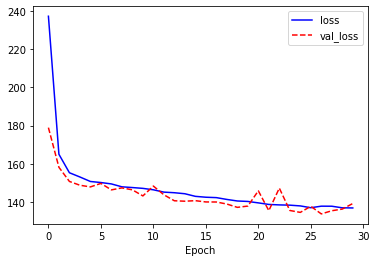

In [14]:
plt.plot(hist.history['loss'], 'b-', label='loss')
plt.plot(hist.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [15]:
results = pd.DataFrame()

for q in q_lst:
    model.compile(loss=lambda y,pred: quantile_loss(q,y,pred), optimizer='adam')
    model.fit(Day, Day78, epochs=epoch, batch_size=48, validation_split=0.25, 
callbacks = [tf.keras.callbacks.EarlyStopping(patience=3, mode='min', monitor='val_loss', verbose=1)])
    pred = pd.DataFrame(model.predict(df_test))
    results = pd.concat([results, pred], axis=1)

results.shape

Epoch 1/100
820/820 [==============================] - 2s 1ms/step - loss: 1.4466 - val_loss: 1.5857
Epoch 2/100
820/820 [==============================] - 1s 1ms/step - loss: 1.4015 - val_loss: 1.5911
Epoch 3/100
820/820 [==============================] - 1s 1ms/step - loss: 1.3885 - val_loss: 1.5875
Epoch 4/100
820/820 [==============================] - 1s 1ms/step - loss: 1.3851 - val_loss: 1.5817
Epoch 5/100
820/820 [==============================] - 1s 1ms/step - loss: 1.3950 - val_loss: 1.5888
Epoch 6/100
820/820 [==============================] - 1s 1ms/step - loss: 1.3919 - val_loss: 1.5936
Epoch 7/100
820/820 [==============================] - 1s 1ms/step - loss: 1.3963 - val_loss: 1.5751
Epoch 8/100
820/820 [==============================] - 1s 1ms/step - loss: 1.4032 - val_loss: 1.5890
Epoch 9/100
820/820 [==============================] - 1s 1ms/step - loss: 1.3972 - val_loss: 1.5817
Epoch 10/100
820/820 [==============================] - 1s 1ms/step - loss: 1.4083 - val_lo

820/820 [==============================] - 2s 2ms/step - loss: 2.7447 - val_loss: 3.1620
Epoch 00004: early stopping
Epoch 1/100
820/820 [==============================] - 2s 2ms/step - loss: 2.6437 - val_loss: 2.9995
Epoch 2/100
820/820 [==============================] - 1s 2ms/step - loss: 2.6233 - val_loss: 3.0241
Epoch 3/100
820/820 [==============================] - 1s 1ms/step - loss: 2.6223 - val_loss: 3.0258
Epoch 4/100
820/820 [==============================] - 1s 1ms/step - loss: 2.6248 - val_loss: 3.0458
Epoch 00004: early stopping
Epoch 1/100
820/820 [==============================] - 1s 1ms/step - loss: 2.3431 - val_loss: 2.6631
Epoch 2/100
820/820 [==============================] - 1s 1ms/step - loss: 2.3206 - val_loss: 2.6859
Epoch 3/100
820/820 [==============================] - 1s 1ms/step - loss: 2.3236 - val_loss: 2.6837
Epoch 4/100
820/820 [==============================] - 1s 1ms/step - loss: 2.3227 - val_loss: 2.6837
Epoch 00004: early stopping
Epoch 1/100
820/820

820/820 [==============================] - 1s 1ms/step - loss: 0.7854 - val_loss: 0.8803
Epoch 2/100
820/820 [==============================] - 1s 1ms/step - loss: 0.7706 - val_loss: 0.9529
Epoch 3/100
820/820 [==============================] - 1s 1ms/step - loss: 0.7775 - val_loss: 0.9230
Epoch 4/100
820/820 [==============================] - 1s 1ms/step - loss: 0.7760 - val_loss: 0.8663
Epoch 5/100
820/820 [==============================] - 1s 1ms/step - loss: 0.7671 - val_loss: 0.8712
Epoch 6/100
820/820 [==============================] - 1s 1ms/step - loss: 0.7696 - val_loss: 0.8625
Epoch 7/100
820/820 [==============================] - 1s 1ms/step - loss: 0.7781 - val_loss: 0.8868
Epoch 8/100
820/820 [==============================] - 1s 1ms/step - loss: 0.7832 - val_loss: 0.8882
Epoch 9/100
820/820 [==============================] - 1s 1ms/step - loss: 0.7624 - val_loss: 0.8661
Epoch 00009: early stopping


(3888, 18)

In [16]:
results[1][:48]

,1,1,1,1,1,1,1,1,1
0,-0.012377,-0.008408,-0.002669,0.005495,0.008699,0.000310,-0.005510,-0.004215,0.008374
1,-0.011908,-0.008797,-0.002492,0.005386,0.008722,0.000491,-0.005051,-0.004180,0.007388
2,-0.010526,-0.004697,-0.000590,0.003816,0.008723,0.000157,-0.002543,0.001161,0.003742
3,-0.010701,-0.004678,-0.000045,0.004220,0.008681,0.000760,-0.002043,0.000600,0.004744
4,-0.011175,-0.002744,-0.001799,0.002283,0.006326,-0.002546,-0.003118,0.000097,0.002712
5,-0.010739,-0.002702,-0.001509,0.002668,0.006632,-0.002185,-0.003657,-0.001281,0.001608
6,-0.011099,-0.003457,-0.001746,0.004306,0.005722,-0.002362,-0.001750,-0.001075,0.002287
7,-0.009779,-0.004186,-0.001002,0.004732,0.006041,-0.002142,-0.001386,-0.000815,0.002213
8,-0.009821,-0.003191,-0.001087,0.005724,0.005217,-0.002203,-0.000805,-0.000230,0.002826
9,-0.011221,-0.003830,-0.001033,0.005764,0.005574,-0.000982,-0.001051,-0.000322,0.003127


In [17]:
from lightgbm import LGBMRegressor

In [18]:
def LGBM(q, X_train, Y_train, X_valid, Y_valid, X_test):
    
    # (a) Modeling  
    model = LGBMRegressor(objective='quantile', alpha=q,
                         n_estimators=10000, bagging_fraction=0.7, learning_rate=0.027, subsample=0.7)                   
                         
                         
    model.fit(X_train, Y_train, eval_metric = ['quantile'], 
          eval_set=[(X_valid, Y_valid)], early_stopping_rounds=300, verbose=500)

    # (b) Predictions
    pred = pd.Series(model.predict(X_test).round(2))
    return pred, model

def train_data(X_train, Y_train, X_valid, Y_valid, X_test):

    LGBM_models=[]
    LGBM_actual_pred = pd.DataFrame()

    for q in q_lst:
        print(q)
        pred , model = LGBM(q, X_train, Y_train, X_valid, Y_valid, X_test)
        LGBM_models.append(model)
        LGBM_actual_pred = pd.concat([LGBM_actual_pred,pred],axis=1)

    LGBM_actual_pred.columns=q_lst
    
    return LGBM_models, LGBM_actual_pred

models_1, results_1 = train_data(X_train_1, Y_train_1, X_valid_1, Y_valid_1, df_test)
models_2, results_2 = train_data(X_train_2, Y_train_2, X_valid_2, Y_valid_2, df_test)

0.1
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 1.34889
Early stopping, best iteration is:
[418]	valid_0's quantile: 1.34812
0.2
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 2.14466
[1000]	valid_0's quantile: 2.13764
[1500]	valid_0's quantile: 2.13582
[2000]	valid_0's quantile: 2.1334
Early stopping, best iteration is:
[1749]	valid_0's quantile: 2.13312
0.3
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 2.53565
[1000]	valid_0's quantile: 2.50726
[1500]	valid_0's quantile: 2.49216
Early stopping, best iteration is:
[1604]	valid_0's quantile: 2.48959
0.4
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 2.66191
[1000]	valid_0's quantile: 2.62846
[1500]	valid_0's quantile: 2.61266
[2000]	valid_0's quantile: 2.6059
[2500]	valid_0's quantile: 2.59923
[3000]	valid_0's quantile: 2.59644
Early stopping, best iteration is:
[2707]	v

In [19]:
results_1[:48]

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [20]:
results_2[:48]

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [21]:
model7 = tf.keras.Sequential([
    layers.Conv1D(filters=128, kernel_size=2, padding='same', activation='relu'),
    layers.Conv1D(filters=64, kernel_size=2, padding='same', activation='relu'),
    layers.Conv1D(filters=32, kernel_size=2, padding='same', activation='relu'),
    layers.Dense(1)
])

result7 = pd.DataFrame()

for q in q_lst:
    print(q)
    model7.compile(loss=lambda y,pred: quantile_loss(q,y,pred), optimizer='adam')
    model7.fit(np.array(Day).reshape(52464, 1, 7), np.array(Day7).reshape(52464, 1), epochs=epoch, batch_size=48, validation_split=0.25, 
                callbacks = [tf.keras.callbacks.EarlyStopping(patience=5, mode='min', monitor='val_loss', verbose=1)])
    pred7 = np.squeeze(model7.predict(np.array(df_test).reshape(3888, 1, 7)))
    pred7 = pd.DataFrame(pred7)
    result7 = pd.concat([result7, pred7], axis=1)
    
result7[:48]

0.1
Epoch 1/100
820/820 [==============================] - 2s 2ms/step - loss: 1.4349 - val_loss: 1.6000
Epoch 2/100
820/820 [==============================] - 1s 2ms/step - loss: 1.4216 - val_loss: 1.6015
Epoch 3/100
820/820 [==============================] - 2s 2ms/step - loss: 1.4128 - val_loss: 1.5976
Epoch 4/100
820/820 [==============================] - 2s 2ms/step - loss: 1.4163 - val_loss: 1.5969
Epoch 5/100
820/820 [==============================] - 2s 2ms/step - loss: 1.4228 - val_loss: 1.6028
Epoch 6/100
820/820 [==============================] - 2s 2ms/step - loss: 1.4143 - val_loss: 1.6123
Epoch 7/100
820/820 [==============================] - 2s 3ms/step - loss: 1.4169 - val_loss: 1.6046
Epoch 8/100
820/820 [==============================] - 2s 2ms/step - loss: 1.4316 - val_loss: 1.5982
Epoch 9/100
820/820 [==============================] - 2s 2ms/step - loss: 1.4212 - val_loss: 1.5966
Epoch 10/100
820/820 [==============================] - 2s 3ms/step - loss: 1.4343 - va

820/820 [==============================] - 1s 2ms/step - loss: 2.2597 - val_loss: 2.6387
Epoch 6/100
820/820 [==============================] - 1s 2ms/step - loss: 2.2867 - val_loss: 2.5970
Epoch 7/100
820/820 [==============================] - 1s 1ms/step - loss: 2.2923 - val_loss: 2.5866
Epoch 8/100
820/820 [==============================] - 1s 2ms/step - loss: 2.3248 - val_loss: 2.6754
Epoch 9/100
820/820 [==============================] - 1s 2ms/step - loss: 2.2687 - val_loss: 2.6127
Epoch 10/100
820/820 [==============================] - 1s 2ms/step - loss: 2.3143 - val_loss: 2.5848
Epoch 11/100
820/820 [==============================] - 1s 2ms/step - loss: 2.2189 - val_loss: 2.6107
Epoch 12/100
820/820 [==============================] - 1s 2ms/step - loss: 2.2302 - val_loss: 2.6353
Epoch 13/100
820/820 [==============================] - 1s 2ms/step - loss: 2.2739 - val_loss: 2.6150
Epoch 14/100
820/820 [==============================] - 2s 2ms/step - loss: 2.2479 - val_loss: 2.60

,0,0,0,0,0,0,0,0,0
0,-0.001560,-0.003694,-0.000657,-0.003570,0.001820,0.001609,-0.000083,0.002688,0.002829
1,-0.001560,-0.003706,-0.000660,-0.003573,0.001820,0.001609,-0.000084,0.002691,0.002832
2,-0.001595,-0.003681,-0.000674,-0.003568,0.001821,0.001612,-0.000073,0.002662,0.002820
3,-0.001587,-0.003675,-0.000672,-0.003569,0.001821,0.001612,-0.000072,0.002660,0.002818
4,-0.001628,-0.003635,-0.000681,-0.003560,0.001822,0.001616,-0.000059,0.002629,0.002803
5,-0.001627,-0.003655,-0.000685,-0.003564,0.001822,0.001615,-0.000062,0.002634,0.002808
6,-0.001660,-0.003625,-0.000696,-0.003557,0.001823,0.001619,-0.000050,0.002606,0.002796
7,-0.001682,-0.003673,-0.000707,-0.003555,0.001823,0.001618,-0.000056,0.002616,0.002806
8,-0.001745,-0.003674,-0.000726,-0.003544,0.001825,0.001620,-0.000048,0.002593,0.002800
9,-0.001749,-0.003713,-0.000736,-0.003547,0.001824,0.001619,-0.000053,0.002599,0.002806


In [22]:
model8 = tf.keras.Sequential([
    layers.Conv1D(filters=128, kernel_size=2, padding='same', activation='relu'),
    layers.Conv1D(filters=64, kernel_size=2, padding='same', activation='relu'),
    layers.Conv1D(filters=32, kernel_size=2, padding='same', activation='relu'),
    layers.Dense(1)
])

result8 = pd.DataFrame()

for q in q_lst:
    print(q)
    model8.compile(loss=lambda y,pred: quantile_loss(q,y,pred), optimizer='adam')
    model8.fit(np.array(Day).reshape(52464, 1, 7), np.array(Day8).reshape(52464, 1), epochs=epoch, batch_size=48, validation_split=0.25, 
                callbacks = [tf.keras.callbacks.EarlyStopping(patience=5, mode='min', monitor='val_loss', verbose=1)])
    pred8 = np.squeeze(model8.predict(np.array(df_test).reshape(3888, 1, 7)))
    pred8 = pd.DataFrame(pred8)
    result8 = pd.concat([result8, pred8], axis=1)
    
result8[:48]

0.1
Epoch 1/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4555 - val_loss: 1.6458
Epoch 2/100
820/820 [==============================] - 2s 2ms/step - loss: 1.4449 - val_loss: 1.6420
Epoch 3/100
820/820 [==============================] - 2s 3ms/step - loss: 1.4339 - val_loss: 1.6405
Epoch 4/100
820/820 [==============================] - 2s 3ms/step - loss: 1.4252 - val_loss: 1.6398
Epoch 5/100
820/820 [==============================] - 2s 3ms/step - loss: 1.4423 - val_loss: 1.6398
Epoch 6/100
820/820 [==============================] - 2s 3ms/step - loss: 1.4344 - val_loss: 1.6460
Epoch 7/100
820/820 [==============================] - 2s 2ms/step - loss: 1.4438 - val_loss: 1.6485
Epoch 8/100
820/820 [==============================] - 2s 2ms/step - loss: 1.4514 - val_loss: 1.6387
Epoch 9/100
820/820 [==============================] - 2s 2ms/step - loss: 1.4509 - val_loss: 1.6418
Epoch 10/100
820/820 [==============================] - 2s 3ms/step - loss: 1.4603 - va

820/820 [==============================] - 2s 2ms/step - loss: 2.7544 - val_loss: 3.1246
Epoch 8/100
820/820 [==============================] - 2s 2ms/step - loss: 2.7526 - val_loss: 3.1195
Epoch 9/100
820/820 [==============================] - 2s 2ms/step - loss: 2.7264 - val_loss: 3.0705
Epoch 10/100
820/820 [==============================] - 2s 2ms/step - loss: 2.7549 - val_loss: 3.0592
Epoch 11/100
820/820 [==============================] - 2s 2ms/step - loss: 2.6973 - val_loss: 3.0757
Epoch 12/100
820/820 [==============================] - 2s 2ms/step - loss: 2.7240 - val_loss: 3.0958
Epoch 13/100
820/820 [==============================] - 2s 2ms/step - loss: 2.7351 - val_loss: 3.0838
Epoch 14/100
820/820 [==============================] - 2s 2ms/step - loss: 2.7281 - val_loss: 3.1608
Epoch 15/100
820/820 [==============================] - 2s 2ms/step - loss: 2.7249 - val_loss: 3.0691
Epoch 00015: early stopping
0.6
Epoch 1/100
820/820 [==============================] - 3s 3ms/ste

,0,0,0,0,0,0,0,0,0
0,0.000406,-0.002769,0.000489,0.000755,-0.000681,-0.000986,-0.000322,0.000442,0.001392
1,0.000406,-0.002769,0.000489,0.000755,-0.000681,-0.000986,-0.000322,0.000442,0.001392
2,0.000406,-0.002769,0.000489,0.000755,-0.000681,-0.000986,-0.000322,0.000442,0.001392
3,0.000406,-0.002769,0.000489,0.000755,-0.000681,-0.000986,-0.000322,0.000442,0.001392
4,0.000406,-0.002769,0.000489,0.000755,-0.000681,-0.000986,-0.000322,0.000442,0.001392
5,0.000406,-0.002769,0.000489,0.000755,-0.000681,-0.000986,-0.000322,0.000442,0.001392
6,0.000406,-0.002769,0.000489,0.000755,-0.000681,-0.000986,-0.000322,0.000442,0.001392
7,0.000406,-0.002769,0.000489,0.000755,-0.000681,-0.000986,-0.000322,0.000442,0.001392
8,0.000406,-0.002769,0.000489,0.000755,-0.000681,-0.000986,-0.000322,0.000442,0.001392
9,0.000406,-0.002769,0.000489,0.000755,-0.000681,-0.000986,-0.000322,0.000442,0.001392


In [23]:
model = tf.keras.Sequential([
    layers.GRU(units=64, return_sequences=True, input_shape=[39348, 7]),
    layers.GRU(units=32),
    layers.Dense(1)
])

model.compile(loss='mse', optimizer='adam')
model.fit(np.array(X_train_1).reshape(39348, 1, 7), np.array(Y_train_1).reshape(39348, 1), epochs=epoch, batch_size=48, validation_split=0.25, 
            callbacks = [tf.keras.callbacks.EarlyStopping(patience=3, mode='min', monitor='val_loss', verbose=1)])
pred = np.squeeze(model8.predict(np.array(X_valid_1).reshape(13116, 1, 7)))

Epoch 1/100
615/615 [==============================] - 8s 5ms/step - loss: 666.7963 - val_loss: 380.6853
Epoch 2/100
615/615 [==============================] - 3s 4ms/step - loss: 319.0092 - val_loss: 238.7392
Epoch 3/100
615/615 [==============================] - 2s 4ms/step - loss: 212.7998 - val_loss: 182.8196
Epoch 4/100
615/615 [==============================] - 2s 4ms/step - loss: 176.4320 - val_loss: 158.7719
Epoch 5/100
615/615 [==============================] - 2s 4ms/step - loss: 152.8708 - val_loss: 147.3703
Epoch 6/100
615/615 [==============================] - 2s 4ms/step - loss: 147.1763 - val_loss: 147.1366
Epoch 7/100
615/615 [==============================] - 2s 4ms/step - loss: 144.5910 - val_loss: 138.9911
Epoch 8/100
615/615 [==============================] - 2s 4ms/step - loss: 136.6039 - val_loss: 138.7947
Epoch 9/100
615/615 [==============================] - 2s 4ms/step - loss: 140.8756 - val_loss: 138.0776
Epoch 10/100
615/615 [==============================] -

In [24]:
model_G7 = tf.keras.Sequential([
    layers.GRU(units=64, return_sequences=True, input_shape=[52464, 7]),
    layers.GRU(units=32),
    layers.Dense(1)
])

result_G7 = pd.DataFrame()

for q in q_lst:
    print(q)
    model_G7.compile(loss=lambda y,pred: quantile_loss(q,y,pred), optimizer='adam')
    model_G7.fit(np.array(Day).reshape(52464, 1, 7), np.array(Day7).reshape(52464, 1)
                 , epochs=epoch, batch_size=48, validation_split=0.25, 
                callbacks = [tf.keras.callbacks.EarlyStopping(patience=5, mode='min', monitor='val_loss', verbose=1)])
    pred_G7 = np.squeeze(model_G7.predict(np.array(df_test).reshape(3888, 1, 7)))
    pred_G7 = pd.DataFrame(pred_G7)
    result_G7 = pd.concat([result_G7, pred_G7], axis=1)
    
result_G7[:48]

0.1
Epoch 1/100
820/820 [==============================] - 8s 5ms/step - loss: 1.5274 - val_loss: 1.6286
Epoch 2/100
820/820 [==============================] - 3s 4ms/step - loss: 1.4350 - val_loss: 1.6110
Epoch 3/100
820/820 [==============================] - 3s 4ms/step - loss: 1.4222 - val_loss: 1.6038
Epoch 4/100
820/820 [==============================] - 3s 4ms/step - loss: 1.4115 - val_loss: 1.6016
Epoch 5/100
820/820 [==============================] - 3s 4ms/step - loss: 1.4166 - val_loss: 1.5898
Epoch 6/100
820/820 [==============================] - 3s 4ms/step - loss: 1.4019 - val_loss: 1.6108
Epoch 7/100
820/820 [==============================] - 3s 4ms/step - loss: 1.4040 - val_loss: 1.5916
Epoch 8/100
820/820 [==============================] - 3s 4ms/step - loss: 1.4179 - val_loss: 1.5810
Epoch 9/100
820/820 [==============================] - 3s 4ms/step - loss: 1.3994 - val_loss: 1.5773
Epoch 10/100
820/820 [==============================] - 3s 4ms/step - loss: 1.4212 - va

Epoch 2/100
820/820 [==============================] - 3s 4ms/step - loss: 2.6131 - val_loss: 2.9885
Epoch 3/100
820/820 [==============================] - 3s 4ms/step - loss: 2.6094 - val_loss: 2.9917
Epoch 4/100
820/820 [==============================] - 3s 4ms/step - loss: 2.5870 - val_loss: 2.9967
Epoch 5/100
820/820 [==============================] - 3s 4ms/step - loss: 2.6233 - val_loss: 2.9884
Epoch 6/100
820/820 [==============================] - 3s 4ms/step - loss: 2.6142 - val_loss: 3.0042
Epoch 7/100
820/820 [==============================] - 3s 4ms/step - loss: 2.6197 - val_loss: 2.9828
Epoch 8/100
820/820 [==============================] - 3s 4ms/step - loss: 2.6516 - val_loss: 2.9878
Epoch 9/100
820/820 [==============================] - 3s 4ms/step - loss: 2.5999 - val_loss: 2.9803
Epoch 10/100
820/820 [==============================] - 3s 4ms/step - loss: 2.6607 - val_loss: 2.9751
Epoch 11/100
820/820 [==============================] - 3s 4ms/step - loss: 2.5538 - val_l

0.6
Epoch 1/100
820/820 [==============================] - 9s 5ms/step - loss: 2.2992 - val_loss: 2.5828
Epoch 2/100
820/820 [==============================] - 4s 4ms/step - loss: 2.2620 - val_loss: 2.5883
Epoch 3/100
820/820 [==============================] - 4s 4ms/step - loss: 2.2705 - val_loss: 2.5933
Epoch 4/100
820/820 [==============================] - 3s 4ms/step - loss: 2.2582 - val_loss: 2.6166
Epoch 5/100
820/820 [==============================] - 4s 4ms/step - loss: 2.2688 - val_loss: 2.6181
Epoch 6/100
820/820 [==============================] - 4s 4ms/step - loss: 2.2792 - val_loss: 2.6371
Epoch 00006: early stopping
0.7
Epoch 1/100
820/820 [==============================] - 6s 4ms/step - loss: 1.8909 - val_loss: 2.1346
Epoch 2/100
820/820 [==============================] - 3s 3ms/step - loss: 1.8525 - val_loss: 2.1136
Epoch 3/100
820/820 [==============================] - 3s 3ms/step - loss: 1.8684 - val_loss: 2.1850
Epoch 4/100
820/820 [==============================] - 

,0,0,0,0,0,0,0,0,0
0,-0.023767,-0.002623,-0.005467,0.008433,0.005853,0.010430,-0.007161,-0.003821,0.007020
1,-0.023680,-0.002665,-0.005973,0.008066,0.005832,0.010751,-0.007089,-0.003456,0.007331
2,-0.023393,-0.002849,-0.006229,0.007898,0.000213,0.007504,-0.006562,-0.003360,0.007389
3,-0.023406,-0.002756,-0.005613,0.008238,0.000344,0.007283,-0.006382,-0.003389,0.007342
4,-0.023227,-0.002963,-0.005545,0.008920,0.000035,0.008081,-0.003639,-0.002846,0.006686
5,-0.023235,-0.003056,-0.006488,0.008471,-0.000313,0.008125,-0.004171,-0.002818,0.006740
6,-0.023190,-0.003287,-0.006752,0.009082,0.000552,0.010395,-0.000611,-0.002114,0.005813
7,-0.023968,-0.003798,-0.009183,0.008247,-0.001208,0.010440,-0.002044,-0.003035,0.005085
8,-0.025139,-0.004484,-0.010663,0.008522,-0.004091,0.011560,0.000861,-0.003804,0.003939
9,-0.025881,-0.004770,-0.011587,0.008291,-0.004916,0.011784,0.000634,-0.004078,0.004025


In [25]:
model_G8 = tf.keras.Sequential([
    layers.GRU(units=64, return_sequences=True, input_shape=[52464, 7]),
    layers.GRU(units=32),
    layers.Dense(1)
])

result_G8 = pd.DataFrame()

for q in q_lst:
    print(q)
    model_G8.compile(loss=lambda y,pred: quantile_loss(q,y,pred), optimizer='adam')
    model_G8.fit(np.array(Day).reshape(52464, 1, 7), np.array(Day7).reshape(52464, 1)
                 , epochs=epoch, batch_size=48, validation_split=0.25, 
                callbacks = [tf.keras.callbacks.EarlyStopping(patience=5, mode='min', monitor='val_loss', verbose=1)])
    pred_G8 = np.squeeze(model_G8.predict(np.array(df_test).reshape(3888, 1, 7)))
    pred_G8 = pd.DataFrame(pred_G8)
    result_G8 = pd.concat([result_G8, pred_G8], axis=1)
    
result_G8[:48]

0.1
Epoch 1/100
820/820 [==============================] - 6s 4ms/step - loss: 1.5320 - val_loss: 1.6294
Epoch 2/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4362 - val_loss: 1.6110
Epoch 3/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4226 - val_loss: 1.6059
Epoch 4/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4122 - val_loss: 1.5978
Epoch 5/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4171 - val_loss: 1.5912
Epoch 6/100
820/820 [==============================] - 3s 4ms/step - loss: 1.4031 - val_loss: 1.6162
Epoch 7/100
820/820 [==============================] - 4s 4ms/step - loss: 1.4048 - val_loss: 1.5945
Epoch 8/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4187 - val_loss: 1.5801
Epoch 9/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4007 - val_loss: 1.5778
Epoch 10/100
820/820 [==============================] - 3s 4ms/step - loss: 1.4225 - va

820/820 [==============================] - 3s 3ms/step - loss: 2.6550 - val_loss: 3.0046
Epoch 9/100
820/820 [==============================] - 3s 3ms/step - loss: 2.6011 - val_loss: 2.9869
Epoch 10/100
820/820 [==============================] - 3s 3ms/step - loss: 2.6617 - val_loss: 2.9871
Epoch 00010: early stopping
0.4
Epoch 1/100
820/820 [==============================] - 6s 4ms/step - loss: 2.7659 - val_loss: 3.1133
Epoch 2/100
820/820 [==============================] - 3s 3ms/step - loss: 2.7318 - val_loss: 3.1047
Epoch 3/100
820/820 [==============================] - 3s 3ms/step - loss: 2.7237 - val_loss: 3.1166
Epoch 4/100
820/820 [==============================] - 3s 3ms/step - loss: 2.7078 - val_loss: 3.1216
Epoch 5/100
820/820 [==============================] - 3s 3ms/step - loss: 2.7479 - val_loss: 3.1230
Epoch 6/100
820/820 [==============================] - 3s 3ms/step - loss: 2.7420 - val_loss: 3.1209
Epoch 7/100
820/820 [==============================] - 3s 3ms/step - l

820/820 [==============================] - 3s 3ms/step - loss: 2.3069 - val_loss: 2.6004
Epoch 26/100
820/820 [==============================] - 3s 3ms/step - loss: 2.2998 - val_loss: 2.5955
Epoch 27/100
820/820 [==============================] - 3s 3ms/step - loss: 2.3436 - val_loss: 2.5861
Epoch 28/100
820/820 [==============================] - 3s 3ms/step - loss: 2.3031 - val_loss: 2.5855
Epoch 29/100
820/820 [==============================] - 3s 3ms/step - loss: 2.2995 - val_loss: 2.6213
Epoch 30/100
820/820 [==============================] - 3s 3ms/step - loss: 2.2986 - val_loss: 2.5685
Epoch 31/100
820/820 [==============================] - 3s 3ms/step - loss: 2.2980 - val_loss: 2.6112
Epoch 32/100
820/820 [==============================] - 3s 3ms/step - loss: 2.3062 - val_loss: 2.6133
Epoch 33/100
820/820 [==============================] - 3s 4ms/step - loss: 2.2775 - val_loss: 2.5929
Epoch 34/100
820/820 [==============================] - 3s 3ms/step - loss: 2.2807 - val_loss: 

820/820 [==============================] - 3s 3ms/step - loss: 0.7433 - val_loss: 0.8615
Epoch 5/100
820/820 [==============================] - 3s 3ms/step - loss: 0.7430 - val_loss: 0.8764
Epoch 6/100
820/820 [==============================] - 3s 3ms/step - loss: 0.7473 - val_loss: 0.8654
Epoch 7/100
820/820 [==============================] - 3s 3ms/step - loss: 0.7595 - val_loss: 0.8572
Epoch 8/100
820/820 [==============================] - 3s 3ms/step - loss: 0.7619 - val_loss: 0.8640
Epoch 00008: early stopping


,0,0,0,0,0,0,0,0,0
0,-0.006080,-0.017239,-0.012890,0.012042,0.016549,0.025605,-0.009659,0.013538,0.007649
1,-0.005739,-0.016900,-0.012668,0.012232,0.016546,0.025031,-0.010068,0.013283,0.007372
2,-0.004688,-0.016395,-0.014915,0.011110,0.013092,0.022475,-0.007171,0.012271,0.005666
3,-0.005095,-0.016614,-0.015043,0.010654,0.013000,0.022952,-0.006833,0.012449,0.005790
4,-0.004355,-0.016381,-0.017238,0.009901,0.010225,0.018400,-0.005015,0.010809,0.004737
5,-0.003740,-0.015905,-0.016838,0.010371,0.010299,0.017918,-0.005138,0.010601,0.004659
6,-0.002873,-0.015461,-0.018507,0.010007,0.008127,0.012516,-0.002963,0.008401,0.004653
7,-0.001166,-0.015176,-0.018372,0.011900,0.008588,0.011227,-0.002961,0.008092,0.005117
8,0.000892,-0.015099,-0.020445,0.013104,0.007344,0.005237,0.002852,0.006293,0.007539
9,0.001886,-0.014946,-0.020554,0.013891,0.007540,0.004938,0.003819,0.006465,0.008529


In [26]:
epoch = 100

model_M7 = tf.keras.Sequential([
    layers.LSTM(units=64, return_sequences=True, input_shape=[52464, 8]),
    layers.LSTM(units=32),
    layers.Dense(1)
])

result_M7 = pd.DataFrame()

for q in q_lst:
    print(q)
    model_M7.compile(loss=lambda y,pred: quantile_loss(q,y,pred), optimizer='adam')
    model_M7.fit(np.array(Day0).reshape(52464, 1, 8), np.array(Day7).reshape(52464, 1)
                 , epochs=epoch, batch_size=48, validation_split=0.25, 
                callbacks = [tf.keras.callbacks.EarlyStopping(patience=3, mode='min', monitor='val_loss', verbose=1)])
    pred_M7 = np.squeeze(model_M7.predict(np.array(df_test0).reshape(3888, 1, 8)))
    pred_M7 = pd.DataFrame(pred_M7)
    result_M7 = pd.concat([result_M7, pred_M7], axis=1)
    
result_M7[:48]

0.1
Epoch 1/100
820/820 [==============================] - 6s 4ms/step - loss: 1.5495 - val_loss: 1.6348
Epoch 2/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4419 - val_loss: 1.6142
Epoch 3/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4231 - val_loss: 1.6086
Epoch 4/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4086 - val_loss: 1.6205
Epoch 5/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4126 - val_loss: 1.5875
Epoch 6/100
820/820 [==============================] - 3s 3ms/step - loss: 1.3956 - val_loss: 1.6490
Epoch 7/100
820/820 [==============================] - 3s 3ms/step - loss: 1.3958 - val_loss: 1.6245
Epoch 8/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4103 - val_loss: 1.6177
Epoch 00008: early stopping
0.2
Epoch 1/100
820/820 [==============================] - 6s 4ms/step - loss: 2.3262 - val_loss: 2.6022
Epoch 2/100
820/820 [==============================] - 

0.5
Epoch 1/100
820/820 [==============================] - 6s 4ms/step - loss: 2.6928 - val_loss: 2.9882
Epoch 2/100
820/820 [==============================] - 3s 3ms/step - loss: 2.6507 - val_loss: 2.9735
Epoch 3/100
820/820 [==============================] - 3s 3ms/step - loss: 2.6382 - val_loss: 2.9780
Epoch 4/100
820/820 [==============================] - 3s 3ms/step - loss: 2.6358 - val_loss: 2.9977
Epoch 5/100
820/820 [==============================] - 2s 3ms/step - loss: 2.6608 - val_loss: 2.9978
Epoch 00005: early stopping
0.6
Epoch 1/100
820/820 [==============================] - 6s 4ms/step - loss: 2.4344 - val_loss: 2.7102
Epoch 2/100
820/820 [==============================] - 3s 3ms/step - loss: 2.3976 - val_loss: 2.6808
Epoch 3/100
820/820 [==============================] - 3s 3ms/step - loss: 2.3832 - val_loss: 2.6813
Epoch 4/100
820/820 [==============================] - 3s 3ms/step - loss: 2.3802 - val_loss: 2.7654
Epoch 5/100
820/820 [==============================] - 

0.9
Epoch 1/100
820/820 [==============================] - 6s 4ms/step - loss: 0.8407 - val_loss: 0.9433
Epoch 2/100
820/820 [==============================] - 3s 3ms/step - loss: 0.8193 - val_loss: 0.9857
Epoch 3/100
820/820 [==============================] - 3s 3ms/step - loss: 0.8342 - val_loss: 0.9345
Epoch 4/100
820/820 [==============================] - 3s 3ms/step - loss: 0.8244 - val_loss: 0.9773
Epoch 5/100
820/820 [==============================] - 2s 3ms/step - loss: 0.8348 - val_loss: 0.9672
Epoch 6/100
820/820 [==============================] - 3s 3ms/step - loss: 0.8270 - val_loss: 0.9493
Epoch 00006: early stopping


,0,0,0,0,0,0,0,0,0
0,-0.019125,-0.019102,-0.007617,-0.005385,0.001388,0.002855,0.020482,0.023319,0.018366
1,-0.019038,-0.018860,-0.007571,-0.005126,0.001064,0.002280,0.019592,0.022475,0.017256
2,-0.018445,-0.018930,-0.008777,-0.007531,-0.000556,-0.000474,0.015187,0.017779,0.009924
3,-0.018493,-0.019040,-0.008770,-0.007772,-0.000332,-0.000109,0.016030,0.018532,0.011051
4,-0.018082,-0.019398,-0.009946,-0.010143,-0.001520,-0.001800,0.013279,0.015594,0.007459
5,-0.017874,-0.018921,-0.009755,-0.009475,-0.001727,-0.002171,0.012406,0.014926,0.005757
6,-0.017307,-0.018858,-0.010540,-0.011035,-0.002522,-0.002984,0.010963,0.013476,0.003971
7,-0.017095,-0.018107,-0.009864,-0.008948,-0.001966,-0.001984,0.010204,0.013302,0.001485
8,-0.016474,-0.017599,-0.009730,-0.008396,-0.000995,0.000788,0.012231,0.015984,0.003385
9,-0.016529,-0.017173,-0.008936,-0.006776,-0.000407,0.001950,0.012892,0.017088,0.003213


In [27]:
model_M8 = tf.keras.Sequential([
    layers.LSTM(units=64, return_sequences=True, input_shape=[52464, 8]),
    layers.LSTM(units=32),
    layers.Dense(1)
])

result_M8 = pd.DataFrame()

for q in q_lst:
    print(q)
    model_M8.compile(loss=lambda y,pred: quantile_loss(q,y,pred), optimizer='adam')
    model_M8.fit(np.array(Day0).reshape(52464, 1, 8), np.array(Day8).reshape(52464, 1)
                 , epochs=epoch, batch_size=48, validation_split=0.25, 
                callbacks = [tf.keras.callbacks.EarlyStopping(patience=3, mode='min', monitor='val_loss', verbose=1)])
    pred_M8 = np.squeeze(model_M8.predict(np.array(df_test0).reshape(3888, 1, 8)))
    pred_M8 = pd.DataFrame(pred_M8)
    result_M8 = pd.concat([result_M8, pred_M8], axis=1)
    
result_M8[:48]

0.1
Epoch 1/100
820/820 [==============================] - 6s 4ms/step - loss: 1.5578 - val_loss: 1.6492
Epoch 2/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4543 - val_loss: 1.6545
Epoch 3/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4309 - val_loss: 1.6668
Epoch 4/100
820/820 [==============================] - 4s 5ms/step - loss: 1.4195 - val_loss: 1.6315
Epoch 5/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4284 - val_loss: 1.6383
Epoch 6/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4158 - val_loss: 1.6592
Epoch 7/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4243 - val_loss: 1.6651
Epoch 00007: early stopping
0.2
Epoch 1/100
820/820 [==============================] - 7s 5ms/step - loss: 2.4313 - val_loss: 2.7407
Epoch 2/100
820/820 [==============================] - 3s 3ms/step - loss: 2.3818 - val_loss: 2.7052
Epoch 3/100
820/820 [==============================] - 

820/820 [==============================] - 3s 3ms/step - loss: 2.9342 - val_loss: 3.2852
Epoch 6/100
820/820 [==============================] - 2s 3ms/step - loss: 2.9161 - val_loss: 3.3128
Epoch 7/100
820/820 [==============================] - 3s 3ms/step - loss: 2.9578 - val_loss: 3.2969
Epoch 8/100
820/820 [==============================] - 3s 3ms/step - loss: 2.9477 - val_loss: 3.5658
Epoch 00008: early stopping
0.5
Epoch 1/100
820/820 [==============================] - 6s 4ms/step - loss: 2.8735 - val_loss: 3.1938
Epoch 2/100
820/820 [==============================] - 3s 3ms/step - loss: 2.8401 - val_loss: 3.1993
Epoch 3/100
820/820 [==============================] - 3s 3ms/step - loss: 2.8312 - val_loss: 3.2003
Epoch 4/100
820/820 [==============================] - 3s 3ms/step - loss: 2.8277 - val_loss: 3.2158
Epoch 00004: early stopping
0.6
Epoch 1/100
820/820 [==============================] - 6s 4ms/step - loss: 2.5951 - val_loss: 2.8839
Epoch 2/100
820/820 [==================

820/820 [==============================] - 6s 4ms/step - loss: 1.5377 - val_loss: 1.7597
Epoch 2/100
820/820 [==============================] - 3s 3ms/step - loss: 1.5193 - val_loss: 1.7246
Epoch 3/100
820/820 [==============================] - 3s 3ms/step - loss: 1.5186 - val_loss: 1.7508
Epoch 4/100
820/820 [==============================] - 3s 4ms/step - loss: 1.5156 - val_loss: 1.7440
Epoch 5/100
820/820 [==============================] - 4s 5ms/step - loss: 1.5250 - val_loss: 1.7621
Epoch 00005: early stopping
0.9
Epoch 1/100
820/820 [==============================] - 6s 4ms/step - loss: 0.8696 - val_loss: 0.9997
Epoch 2/100
820/820 [==============================] - 3s 3ms/step - loss: 0.8533 - val_loss: 1.0148
Epoch 3/100
820/820 [==============================] - 3s 4ms/step - loss: 0.8520 - val_loss: 0.9771
Epoch 4/100
820/820 [==============================] - 3s 4ms/step - loss: 0.8531 - val_loss: 0.9603
Epoch 5/100
820/820 [==============================] - 3s 3ms/step - lo

,0,0,0,0,0,0,0,0,0
0,-0.004459,-0.008705,-0.016331,-0.012873,0.011366,0.014229,0.009576,0.031540,0.039548
1,-0.004180,-0.008579,-0.016586,-0.012574,0.011626,0.013720,0.010237,0.032769,0.040871
2,-0.004035,-0.008178,-0.017271,-0.010843,0.011422,0.008403,0.004604,0.022989,0.034962
3,-0.004286,-0.008284,-0.016949,-0.011166,0.011336,0.009346,0.004492,0.022585,0.034200
4,-0.004504,-0.008215,-0.017544,-0.010111,0.010687,0.005679,0.003218,0.019797,0.035764
5,-0.003969,-0.007754,-0.017774,-0.009390,0.011333,0.004812,0.003572,0.020536,0.036747
6,-0.003969,-0.007321,-0.018142,-0.008168,0.011212,0.002407,0.005245,0.022477,0.042794
7,-0.002918,-0.006726,-0.019038,-0.006386,0.011956,-0.000580,0.004924,0.022463,0.043593
8,-0.002470,-0.005955,-0.020004,-0.004453,0.011636,-0.003809,0.006939,0.024896,0.050150
9,-0.002085,-0.006459,-0.020982,-0.004370,0.010595,-0.005873,0.005827,0.023954,0.049952


In [28]:
res_L0 = pd.DataFrame(results_1.sort_index())
res_L0.columns = ['L00.1','L00.2','L00.3','L00.4','L00.5','L00.6','L00.7','L00.8','L00.9']
res_L1 = pd.DataFrame(results_2.sort_index())
res_L1.columns = ['L10.1','L10.2','L10.3','L10.4','L10.5','L10.6','L10.7','L10.8','L10.9']

res_D0 = pd.DataFrame(results[0].sort_index())
res_D0.columns = ['D00.1','D00.2','D00.3','D00.4','D00.5','D00.6','D00.7','D00.8','D00.9']
res_D1 = pd.DataFrame(results[1].sort_index())
res_D1.columns = ['D10.1','D10.2','D10.3','D10.4','D10.5','D10.6','D10.7','D10.8','D10.9']

res_C0 = pd.DataFrame(result7.sort_index())
res_C0.columns = ['C00.1','C00.2','C00.3','C00.4','C00.5','C00.6','C00.7','C00.8','C00.9']
res_C1 = pd.DataFrame(result8.sort_index())
res_C1.columns = ['C10.1','C10.2','C10.3','C10.4','C10.5','C10.6','C10.7','C10.8','C10.9']

res_G0 = pd.DataFrame(result_G7.sort_index())
res_G0.columns = ['G00.1','G00.2','G00.3','G00.4','G00.5','G00.6','G00.7','G00.8','G00.9']
res_G1 = pd.DataFrame(result_G8.sort_index())
res_G1.columns = ['G10.1','G10.2','G10.3','G10.4','G10.5','G10.6','G10.7','G10.8','G10.9']

res_M0 = pd.DataFrame(result_M7.sort_index())
res_M0.columns = ['M00.1','M00.2','M00.3','M00.4','M00.5','M00.6','M00.7','M00.8','M00.9']
res_M1 = pd.DataFrame(result_M8.sort_index())
res_M1.columns = ['M10.1','M10.2','M10.3','M10.4','M10.5','M10.6','M10.7','M10.8','M10.9']

In [29]:
res_0 = pd.DataFrame()
res_1= pd.DataFrame()
res_0 = pd.concat([res_L0, res_D0, res_C0, res_G0, res_M0], axis=1)
res_1 = pd.concat([res_L1, res_D1, res_C1, res_G1, res_M1], axis=1)

In [30]:
res_0[:48]

,L00.1,L00.2,L00.3,L00.4,L00.5,L00.6,L00.7,L00.8,L00.9,D00.1,...,G00.9,M00.1,M00.2,M00.3,M00.4,M00.5,M00.6,M00.7,M00.8,M00.9
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.004501,...,0.007020,-0.019125,-0.019102,-0.007617,-0.005385,0.001388,0.002855,0.020482,0.023319,0.018366
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.004412,...,0.007331,-0.019038,-0.018860,-0.007571,-0.005126,0.001064,0.002280,0.019592,0.022475,0.017256
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.003122,...,0.007389,-0.018445,-0.018930,-0.008777,-0.007531,-0.000556,-0.000474,0.015187,0.017779,0.009924
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.003097,...,0.007342,-0.018493,-0.019040,-0.008770,-0.007772,-0.000332,-0.000109,0.016030,0.018532,0.011051
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.002667,...,0.006686,-0.018082,-0.019398,-0.009946,-0.010143,-0.001520,-0.001800,0.013279,0.015594,0.007459
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.002604,...,0.006740,-0.017874,-0.018921,-0.009755,-0.009475,-0.001727,-0.002171,0.012406,0.014926,0.005757
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.002187,...,0.005813,-0.017307,-0.018858,-0.010540,-0.011035,-0.002522,-0.002984,0.010963,0.013476,0.003971
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.001872,...,0.005085,-0.017095,-0.018107,-0.009864,-0.008948,-0.001966,-0.001984,0.010204,0.013302,0.001485
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.001634,...,0.003939,-0.016474,-0.017599,-0.009730,-0.008396,-0.000995,0.000788,0.012231,0.015984,0.003385
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.003119,...,0.004025,-0.016529,-0.017173,-0.008936,-0.006776,-0.000407,0.001950,0.012892,0.017088,0.003213


In [31]:
res_1[:48]

,L10.1,L10.2,L10.3,L10.4,L10.5,L10.6,L10.7,L10.8,L10.9,D10.1,...,G10.9,M10.1,M10.2,M10.3,M10.4,M10.5,M10.6,M10.7,M10.8,M10.9
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.012377,...,0.007649,-0.004459,-0.008705,-0.016331,-0.012873,0.011366,0.014229,0.009576,0.031540,0.039548
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.011908,...,0.007372,-0.004180,-0.008579,-0.016586,-0.012574,0.011626,0.013720,0.010237,0.032769,0.040871
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.010526,...,0.005666,-0.004035,-0.008178,-0.017271,-0.010843,0.011422,0.008403,0.004604,0.022989,0.034962
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.010701,...,0.005790,-0.004286,-0.008284,-0.016949,-0.011166,0.011336,0.009346,0.004492,0.022585,0.034200
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.011175,...,0.004737,-0.004504,-0.008215,-0.017544,-0.010111,0.010687,0.005679,0.003218,0.019797,0.035764
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.010739,...,0.004659,-0.003969,-0.007754,-0.017774,-0.009390,0.011333,0.004812,0.003572,0.020536,0.036747
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.011099,...,0.004653,-0.003969,-0.007321,-0.018142,-0.008168,0.011212,0.002407,0.005245,0.022477,0.042794
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.009779,...,0.005117,-0.002918,-0.006726,-0.019038,-0.006386,0.011956,-0.000580,0.004924,0.022463,0.043593
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.009821,...,0.007539,-0.002470,-0.005955,-0.020004,-0.004453,0.011636,-0.003809,0.006939,0.024896,0.050150
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.011221,...,0.008529,-0.002085,-0.006459,-0.020982,-0.004370,0.010595,-0.005873,0.005827,0.023954,0.049952


In [32]:
res_0.loc[res_0[res_0['L00.1'] == 0].index, ['D00.1','D00.2','D00.3','D00.4','D00.5','D00.6','D00.7','D00.8','D00.9'
                                            ,'C00.1','C00.2','C00.3','C00.4','C00.5','C00.6','C00.7','C00.8','C00.9'
                                            ,'G00.1','G00.2','G00.3','G00.4','G00.5','G00.6','G00.7','G00.8','G00.9'
                                            ,'M00.1','M00.2','M00.3','M00.4','M00.5','M00.6','M00.7','M00.8','M00.9'
                                            ]] = 0
res_1.loc[res_1[res_1['L10.1'] == 0].index, ['D10.1','D10.2','D10.3','D10.4','D10.5','D10.6','D10.7','D10.8','D10.9'
                                            ,'C10.1','C10.2','C10.3','C10.4','C10.5','C10.6','C10.7','C10.8','C10.9'
                                            ,'G10.1','G10.2','G10.3','G10.4','G10.5','G10.6','G10.7','G10.8','G10.9'
                                            ,'M10.1','M10.2','M10.3','M10.4','M10.5','M10.6','M10.7','M10.8','M10.9'
                                            ]] = 0

In [33]:
res_0[:48]#.to_csv('0.csv', index=False)

,L00.1,L00.2,L00.3,L00.4,L00.5,L00.6,L00.7,L00.8,L00.9,D00.1,...,G00.9,M00.1,M00.2,M00.3,M00.4,M00.5,M00.6,M00.7,M00.8,M00.9
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [34]:
res_1[:48]#.to_csv('0.csv', index=False)

,L10.1,L10.2,L10.3,L10.4,L10.5,L10.6,L10.7,L10.8,L10.9,D10.1,...,G10.9,M10.1,M10.2,M10.3,M10.4,M10.5,M10.6,M10.7,M10.8,M10.9
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [35]:
for i in range(1, 10):
    res_0["L00."+str(i)] = (res_0["L00."+str(i)] + res_0["D00."+str(i)] + res_0["C00."+str(i)] + res_0["G00."+str(i)] + res_0["M00."+str(i)])/5
    res_1["L10."+str(i)] = (res_1["L10."+str(i)] + res_1["D10."+str(i)] + res_1["C10."+str(i)] + res_1["G10."+str(i)] + res_1["M10."+str(i)])/5

In [36]:
submission.loc[submission.id.str.contains("Day7"), "q_0.1":] = res_0[['L00.1','L00.2','L00.3','L00.4','L00.5','L00.6','L00.7','L00.8','L00.9']].values
submission.loc[submission.id.str.contains("Day8"), "q_0.1":] = res_1[['L10.1','L10.2','L10.3','L10.4','L10.5','L10.6','L10.7','L10.8','L10.9']].values
submission[:48]

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
0,0.csv_Day7_0h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.csv_Day7_0h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.csv_Day7_1h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.csv_Day7_1h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.csv_Day7_2h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.csv_Day7_2h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.csv_Day7_3h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.csv_Day7_3h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.csv_Day7_4h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.csv_Day7_4h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [37]:
submission.to_csv('./submission/submission_20210125-1.csv', index=False)